### Predict the prices of the house

Dataset available at {https://www.kaggle.com/c/house-prices-advanced-regression-techniques}

In [4]:
!ls data/house_prices/

sample_submission.csv    submission2018-02-23.csv train.csv
submission.csv           test.csv


In [5]:
import pandas as pd
import numpy as np
import datetime

In [6]:
PATH = "data/house_prices/"

In [7]:
train = pd.read_csv(f'{PATH}train.csv')
test = pd.read_csv(f'{PATH}test.csv')
dataset = pd.concat([train, test], axis=0)

In [8]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [9]:
dataset.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


Since the competition evaluates on the Root-Mean-Squared-Error (RMSE), we take the log of the price to be able to evaluate our accuracy accordingly.

In [10]:
dataset['SalePrice'] = np.log(dataset['SalePrice'])

# Initial data processing

The idea now is to get rid of categories in the string format in the dataset, converting them to numerical values.
Also, NaN values will be categorized too.

## Feature engineering

The fast.ai package offers great methods for manipulating data. It would be great if we had info regarding the day the house was sold, but we only have data regarding month and year. Too bad.

Therefore the only processing I will make is to convert the categorical values into numerical ones, for efficiency purposes and also because random forests need them as numerical values anyways.

In [11]:
from fastai.imports import *
from fastai.structured import *

In [12]:
#??train_cats

In [13]:
# it makes inplace by default
train_cats(dataset)

In [14]:
# We can specify the orders of the categories if we like
#with pd.option_context("display.max_columns", 1000): 
#    display(dataset)

We cannot pass the NaN values to the Random forest. Let's check those.

In [15]:
dataset.isnull().sum().sort_values()/len(dataset)

1stFlrSF         0.000000
YearRemodAdd     0.000000
HeatingQC        0.000000
HouseStyle       0.000000
Id               0.000000
KitchenAbvGr     0.000000
LandContour      0.000000
LandSlope        0.000000
LotArea          0.000000
LotConfig        0.000000
LotShape         0.000000
LowQualFinSF     0.000000
MSSubClass       0.000000
MiscVal          0.000000
HalfBath         0.000000
MoSold           0.000000
OpenPorchSF      0.000000
OverallCond      0.000000
OverallQual      0.000000
PavedDrive       0.000000
PoolArea         0.000000
RoofMatl         0.000000
RoofStyle        0.000000
SaleCondition    0.000000
ScreenPorch      0.000000
Street           0.000000
TotRmsAbvGrd     0.000000
WoodDeckSF       0.000000
YearBuilt        0.000000
Neighborhood     0.000000
                   ...   
TotalBsmtSF      0.000343
GarageCars       0.000343
Exterior1st      0.000343
KitchenQual      0.000343
Exterior2nd      0.000343
Electrical       0.000343
Functional       0.000685
Utilities   

So we see from the NaN analysis above that the categories Fence, Alley, MiscFeature and PoolQC have more than 80% of NaNs.

In [16]:
#??proc_df

In [17]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

In [18]:
df, y, nas = proc_df(dataset, 'SalePrice')
validation_set_len = 300
X_train_raw, X_test = split_vals(df, len(train))
X_train, X_valid = split_vals(X_train_raw, len(train)-validation_set_len)

y_raw, y_test = split_vals(y, len(train))
y_train, y_valid = split_vals(y_raw, len(train) - validation_set_len)

In [20]:
print(df.shape, X_train.shape, X_test.shape, X_valid.shape, y_valid.shape, y_train.shape, y_test.shape)

(2919, 91) (1160, 91) (1459, 91) (300, 91) (300,) (1160,) (1459,)


In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
# Let's train the Random Forest
m = RandomForestRegressor(n_jobs=-1, max_depth=10)
m.fit(X_train, y_train)
m.score(X_train, y_train)

0.9659330682194472

In [23]:
# Let's define some helpful methods for error calculation
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [24]:
X_valid.shape, y_valid.shape

((300, 91), (300,))

In [25]:
m = RandomForestRegressor(n_jobs=-1, max_depth=10)
%time m.fit(X_train, y_train)
#m.score(X_train, y_train)
print_score(m)

CPU times: user 180 ms, sys: 3.91 ms, total: 184 ms
Wall time: 121 ms
[0.07095694034367599, 0.1623450447604778, 0.9688456823831749, 0.8254421467431583]


In [ ]:
# We see from the above that the RMSE for the test set is around 0.15.
# Let's predict on the test dataset and submit to Kaggle to see how well it goes.

In [26]:
def export_predicted_test(m, test_dataset):
    test_dataset['SalePrice'] = m.predict(test_dataset)
    test_dataset['SalePrice'] = np.exp(test_dataset['SalePrice'])
    x = datetime.datetime.now().date()
    test_dataset[['Id','SalePrice']].sort_values('Id').to_csv(f'{PATH}submission{x}.csv',
                                                              index=False, header=True)

# Applying bagging

Let's check the influence of the number of estimators on the train accuracy.

In [27]:
#??print_score

In [28]:
X_test.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,BsmtFinSF2_na,BsmtFullBath_na,BsmtHalfBath_na,BsmtUnfSF_na,GarageArea_na,GarageCars_na,GarageYrBlt_na,LotFrontage_na,MasVnrArea_na,TotalBsmtSF_na
0,896,0,0,0,2,1,4,4,468.0,144.0,...,False,False,False,False,False,False,False,False,False,False
1,1329,0,0,0,3,1,4,4,923.0,0.0,...,False,False,False,False,False,False,False,False,False,False
2,928,701,0,0,3,1,4,4,791.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,926,678,0,0,3,1,4,4,602.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,1280,0,0,0,2,5,4,4,263.0,0.0,...,False,False,False,False,False,False,False,False,False,False


In [29]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.06280872866039747, 0.16478263409280325, 0.9755899601898387, 0.820160867263759]


In [30]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([12.01974, 11.8494 , 11.90834, 11.90834, 11.82408, 12.03172, 11.68568, 11.90834, 11.90834, 11.90834]),
 11.895232588930762,
 11.891361900690473)

Text(0.5,1,'R^2 score vs number of estimators')

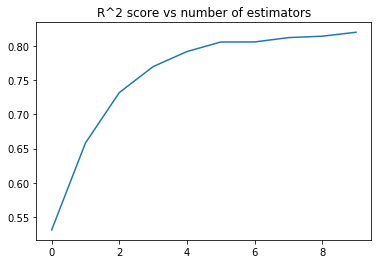

In [31]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);
plt.title("R^2 score vs number of estimators")

As we can see from the graph above, the number of estimators reaches a plateau at about 8 estimators, so it should not make a huge difference to use more than 8-10 estimators.

We can also take a look at the oob (out-of-bag) score, to check how well our model generalizes with the data.

In [33]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators=12)
m.fit(X_train, y_train)
print_score(m)

/Users/gabrielfior/miniconda3/envs/pytorch36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.06425062152903051, 0.15250678326550923, 0.9744563386063577, 0.8459578259012189, -1.4438482882308739]


### Reducing overfitting

The idea here is to avoid overfitting the training data, hence limiting the amount of the data each estimator has access to.

In [34]:
set_rf_samples(200)

In [35]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 69.7 ms, sys: 4.29 ms, total: 74 ms
Wall time: 126 ms
[0.14289657209446935, 0.17279548793999902, 0.8736509142615162, 0.8022456189537233, 0.8231186933622148]


One can see from above that the accuracy in the training data is reduced. No magic here, since the amount of training data per tree was reduced.

### Tree building parameters

We will now see if we can fine tune parameters such as min_samples_leaf, number of estimators and max_features.
First, we need a baseline to compare to, which will be the forest tree without hypertuning.

In [36]:
reset_rf_samples()

In [37]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.05496720078407226, 0.15331894738074564, 0.9813045585618443, 0.8443127757729296, 0.8642539125429713]


Now we will try to get the best parameters for the random forest by performing a grid-search (as shown [here](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74))

In [38]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}


In [39]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.1s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [40]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [41]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [42]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_valid, y_valid)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_valid, y_valid)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.1090 degrees.
Accuracy = 99.09%.
Model Performance
Average Error: 0.0923 degrees.
Accuracy = 99.23%.
Improvement of 0.14%.


In [43]:
print_score(best_random)

[0.039842749899154595, 0.1423005712381762, 0.9901773856633028, 0.8658858489859803]


So we can see that, by playing with the hyperparameters, we could improve from 0.84 to 0.871 accuracy. Let's generate the predictions for the test data and upload to Kaggle to see how we did.

In [44]:
export_predicted_test(best_random, X_test)

We had a score of 0.14674 in the test dataset, which is reasonable given our performance on the validation set.
I am glad that the hyper tuning proved itself to be useful. Let's check the next lectures of Jeremy to see how we can improve our models even more.